# Architectural Tradeoff Analysis (PCA)

In [93]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from paretoset import paretoset
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar

In [94]:
# Read simulation data
# Full = with SQS
df_full = pd.DataFrame(
    pd.read_csv(r"C:\Users\KarlO\architectural-tradeoff-analysis\Simulation data\official_runs\full_1.csv"))
# Simple = without SQS
df_simple = pd.DataFrame(
    pd.read_csv(r"C:\Users\KarlO\architectural-tradeoff-analysis\Simulation data\official_runs\simple_1.csv"))

df = pd.concat([df_full, df_simple])

In [95]:
df_scatter = df.copy()
df_scatter["e_SQS"] = df_scatter["e_SQS"].astype(str)
fig = px.scatter_matrix(df_scatter,
    dimensions=['queue_size', 'timeout','parallel_instances','lambda_chunk_size'],
    color="e_SQS",
    title = "Scatter matrix of parameters")
fig.update_traces(diagonal_visible=False)

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)
        
fig.show()

In [206]:
ct_df = df[['time', 'cost']]

ct_nonoptimal = ct_df.copy()
df_nonoptimal = df.copy()

optimal = []

for i in range(600):
    mask = paretoset(ct_nonoptimal, sense=["min", "min"])
    masklist = mask.tolist()
    indices = [index for (index, item) in enumerate(masklist) if item == True]
    ct_nonoptimal.drop(ct_nonoptimal.index[indices], inplace=True)
    df_nonoptimal.drop(df_nonoptimal.index[indices], inplace=True)
    
df_pareto= pd.concat([df, df_nonoptimal])
df_pareto = df_pareto.drop_duplicates(keep=False)
# Filter outliers
df_pareto = df_pareto[df_pareto.time < 80]

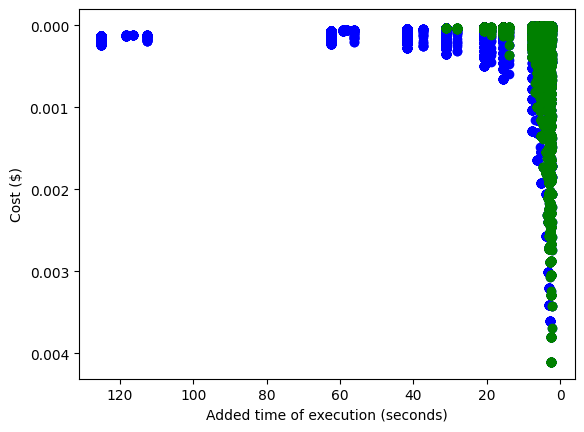

In [207]:
plt.scatter(df['time'], df['cost'], color='b')
#plt.scatter(df_filtered_nonoptimal['time'], df_filtered_nonoptimal['cost'], color='r')
plt.scatter(df_pareto['time'], df_pareto['cost'], color='g')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel('Added time of execution (seconds)')
plt.ylabel('Cost ($)')
plt.show()

In [209]:
# Scale dataframe (gets turned into ndarray which gets retransformed back to dataframe)
scaled_ndarr = preprocessing.scale(df_pareto)
scaled_df = pd.DataFrame(scaled_ndarr, columns = df_pareto.columns)

# Create correlation matrix
corr_scaled_opt = scaled_df.corr()
corr_scaled_opt = corr_scaled_opt.fillna(0)

# Same for full matrix (without pareto)
scaled_ndarr = preprocessing.scale(df_pareto)
scaled_df = pd.DataFrame(scaled_ndarr, columns = df_pareto.columns)

corr_scaled = scaled_df.corr()
corr_scaled = corr_scaled.fillna(0)

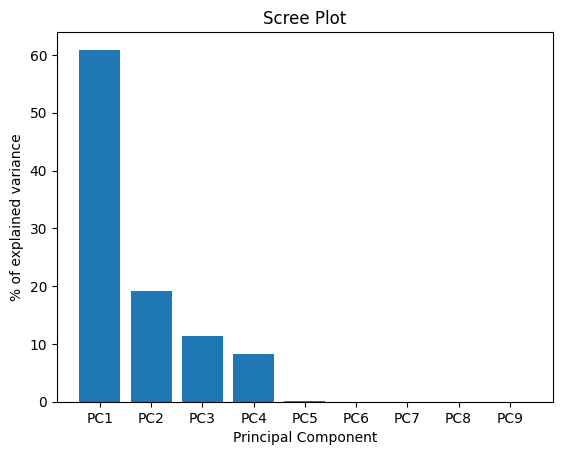

In [212]:
corr_matrix_arr = corr_scaled.to_numpy()
pca = PCA()
#pca.fit(scaled_df)
pca.fit(corr_matrix_arr)
#pca_data = pca.transform(scaled_df)
pca_data = pca.transform(corr_matrix_arr)
# Calculate percentage of variation that each PC (principal component) accounts for
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
# Create labels
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
# Plot scree plot
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('% of explained variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

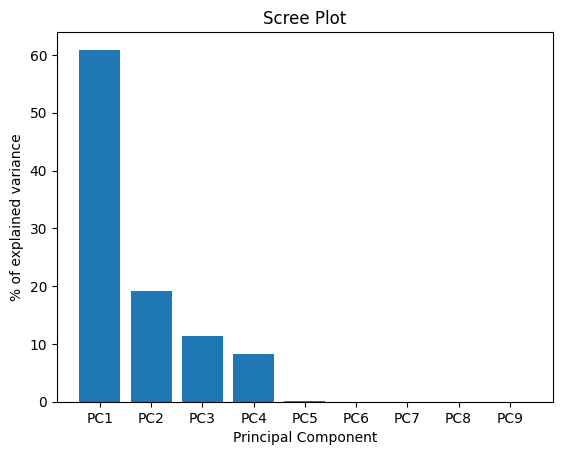

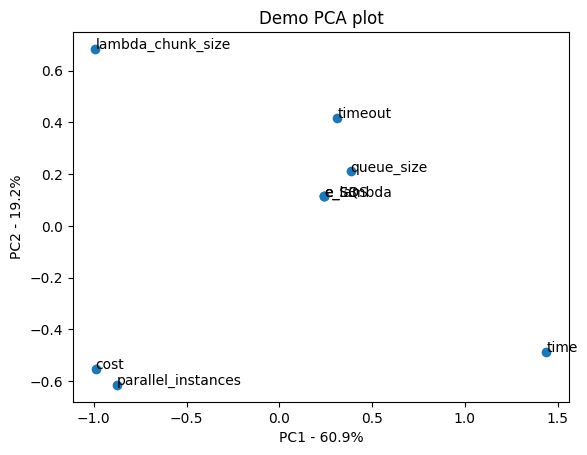

In [211]:
# Calculate percentage of variation that each PC (principal component) accounts for
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
# Create labels
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
# Plot scree plot
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('% of explained variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

pca_df = pd.DataFrame(pca_data, index=corr_matrix.columns, columns=labels)

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('Demo PCA plot')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
                 
plt.show()